<a href="https://colab.research.google.com/github/ellyanalinden/dog_cat_densenet121/blob/master/Copy_of_Part_8_Transfer_Learning_(Exercises).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning

In this notebook, you'll learn how to use pre-trained networks to solved challenging problems in computer vision. Specifically, you'll use networks trained on [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html). 

ImageNet is a massive dataset with over 1 million labeled images in 1000 categories. It's used to train deep neural networks using an architecture called convolutional layers. I'm not going to get into the details of convolutional networks here, but if you want to learn more about them, please [watch this](https://www.youtube.com/watch?v=2-Ol7ZB0MmU).

Once trained, these models work astonishingly well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called transfer learning. Here we'll use transfer learning to train a network that can classify our cat and dog photos with near perfect accuracy.

With `torchvision.models` you can download these pre-trained networks and use them in your applications. We'll include `models` in our imports now.

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import os

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models

In [2]:
!wget --no-check-certificate \
    https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip \

--2019-07-13 23:26:48--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.237.77
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.237.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘Cat_Dog_data.zip’

Cat_Dog_data.zip    100%[===================>] 553.60M  13.4MB/s    in 96s     

2019-07-13 23:28:26 (5.75 MB/s) - ‘Cat_Dog_data.zip’ saved [580495262/580495262]



In [3]:
!unzip -o Cat_Dog_data.zip

Archive:  Cat_Dog_data.zip
   creating: Cat_Dog_data/
  inflating: Cat_Dog_data/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/Cat_Dog_data/
  inflating: __MACOSX/Cat_Dog_data/._.DS_Store  
   creating: Cat_Dog_data/test/
   creating: Cat_Dog_data/test/cat/
  inflating: Cat_Dog_data/test/cat/cat.7660.jpg  
   creating: __MACOSX/Cat_Dog_data/test/
   creating: __MACOSX/Cat_Dog_data/test/cat/
  inflating: __MACOSX/Cat_Dog_data/test/cat/._cat.7660.jpg  
  inflating: Cat_Dog_data/test/cat/cat.1211.jpg  
  inflating: __MACOSX/Cat_Dog_data/test/cat/._cat.1211.jpg  
  inflating: Cat_Dog_data/test/cat/cat.1563.jpg  
  inflating: __MACOSX/Cat_Dog_data/test/cat/._cat.1563.jpg  
  inflating: Cat_Dog_data/test/cat/cat.1205.jpg  
  inflating: __MACOSX/Cat_Dog_data/test/cat/._cat.1205.jpg  
  inflating: Cat_Dog_data/test/cat/cat.7884.jpg  
  inflating: __MACOSX/Cat_Dog_data/test/cat/._cat.7884.jpg  
  inflating: Cat_Dog_data/test/cat/cat.6542.jpg  
  inflating: __MACOSX/Cat_Dog_data/test/c

Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.

In [0]:
data_dir = 'Cat_Dog_data'

# TODO: Define transforms for the training data, validation and testing data
data_transforms = {
    "train_transforms": transforms.Compose([transforms.RandomRotation(30),
                                            transforms.RandomResizedCrop(224),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor()]),
                                            #transforms.Normalize([0.485, 0.456, 0.406],
                                                                 #[0.229, 0.224, 0.225])]),

  
    "test_transforms":  transforms.Compose([transforms.Resize(255),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor()])
                                            #transforms.Normalize([0.485, 0.456, 0.406],
                                                                 #[0.229, 0.224, 0.225])])
}

In [0]:
# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=data_transforms["train_transforms"])
test_data = datasets.ImageFolder(data_dir + '/test', transform=data_transforms["test_transforms"])

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

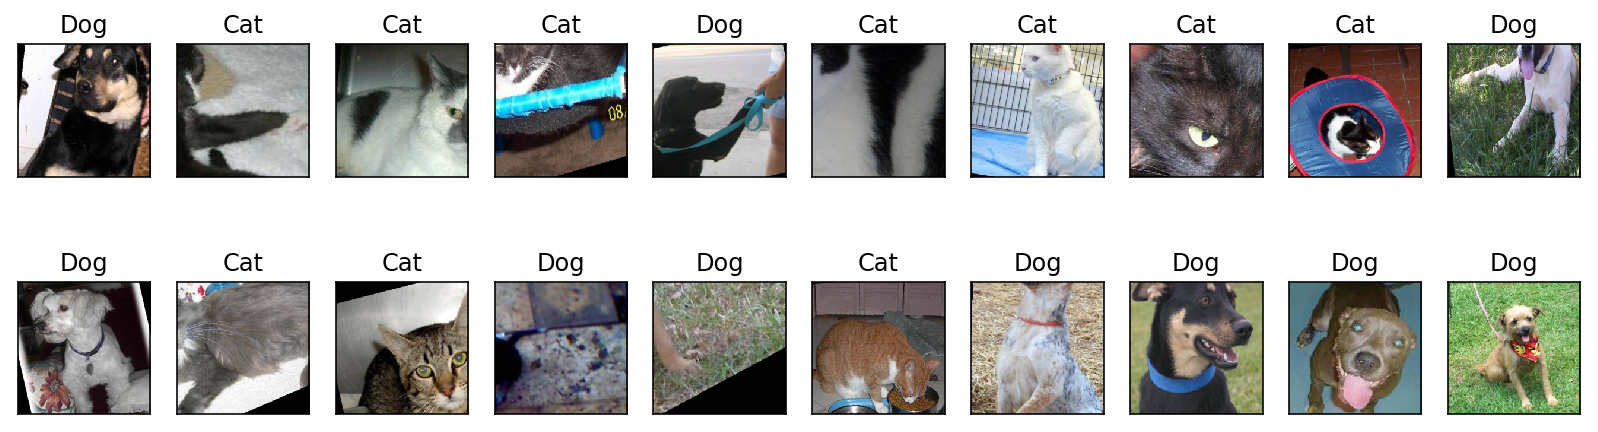

In [0]:
# Visualize some sample data
classes=["Cat", 'Dog']

# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(14, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))#imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [6]:
# Specify model architecture
# Load the pretrained model from pytorch
model_transfer = models.densenet121(pretrained=True)

# Check if GPU is available
use_cuda = torch.cuda.is_available()
if use_cuda:
  model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 115469954.78it/s]


We can load in a model such as [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5). Let's print out the model architecture so we can see what's going on.

In [0]:
# Print out the model structure
print(model_transfer)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [0]:
print(model_transfer.classifier.in_features)
print(model_transfer.classifier.out_features)

1024
1000


This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer `(classifier): Linear(in_features=1024, out_features=1000)`. This layer was trained on the ImageNet dataset, so it won't work for our specific problem. That means we need to replace the classifier, but the features will work perfectly on their own. In general, I think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

In [0]:
# Freeze parameters so we don't backprop through them
for param in model_transfer.features.parameters():
  param.requires_grad = False 

In [9]:
# Total image label
classes=["Cat", 'Dog']

n_inputs = model_transfer.classifier.in_features

#Add last linear layer (n_inputs --> 2 classes)
#New layer automatically has requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

model_transfer.classifier = last_layer

# If GPU is available, move the model to GPU
if use_cuda:
  model_transfer = model_transfer.cuda()
  
# Check to see the last layer produces the expected number of outputs
print(model_transfer.classifier.out_features)

2


With our model built, we need to train the classifier. However, now we're using a **really deep** neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds. It's also possible to train on multiple GPUs, further decreasing training time.

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

In [0]:
'''import time'''

In [0]:
'''for device in ['cpu', 'cuda']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)

    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii==3:
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")'''

Device = cpu; Time per batch: 7.060 seconds
Device = cuda; Time per batch: 0.023 seconds


In [0]:
#Specify loss function and optimizer
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.01, momentum = 0.9)

In [26]:
# number of epochs to train the model
n_epochs = 1

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(trainloader):
        # move tensors to GPU if CUDA is available
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer_transfer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_transfer(data)
        # calculate the batch loss
        loss = criterion_transfer(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer_transfer.step()
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

Epoch 1, Batch 20 loss: 0.8634684827178717
Epoch 1, Batch 40 loss: 0.5692687399685383
Epoch 1, Batch 60 loss: 0.4741607354022562
Epoch 1, Batch 80 loss: 0.6080258028581739
Epoch 1, Batch 100 loss: 0.5579600580036640
Epoch 1, Batch 120 loss: 0.4978255301713944
Epoch 1, Batch 140 loss: 0.5692845813930034
Epoch 1, Batch 160 loss: 0.4952631570398808
Epoch 1, Batch 180 loss: 0.4340699817985296
Epoch 1, Batch 200 loss: 0.5714331936091185
Epoch 1, Batch 220 loss: 0.6099363923072815
Epoch 1, Batch 240 loss: 0.5700827127788216
Epoch 1, Batch 260 loss: 0.5701693236827851
Epoch 1, Batch 280 loss: 0.4348913116380572
Epoch 1, Batch 300 loss: 0.4262750262860209
Epoch 1, Batch 320 loss: 0.6449097321368754
Epoch 1, Batch 340 loss: 0.3062054274603724


In [27]:
loaders_transfer = {'test': testloader}
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model_transfer.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
# call test function    
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.168368


Test Accuracy: 98% (2451/2500)


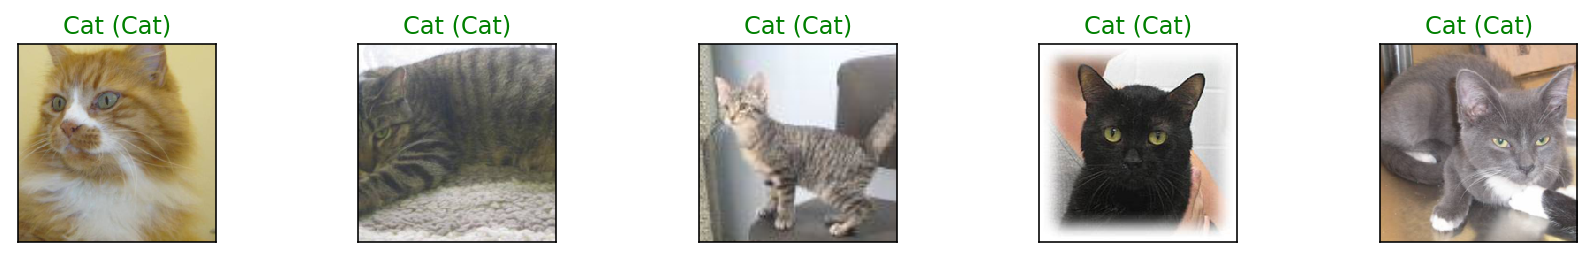

In [34]:
# view the prediction
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if use_cuda:
    images = images.cuda()

# get sample outputs
output = model_transfer(images)

# convert output probabilities to predicted class
_, preds_tensor = torch.max(output,1)
preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
#np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(30, 4))
for idx in np.arange(5):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images.cpu()[idx], (1,2,0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

From here, I'll let you finish training the model. The process is the same as before except now your model is much more powerful. You should get better than 95% accuracy easily.

>**Exercise:** Train a pretrained models to classify the cat and dog images. Continue with the DenseNet model, or try ResNet, it's also a good model to try out first. Make sure you are only training the classifier and the parameters for the features part are frozen.